In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['news-dataset', 'glove50']


In [110]:
import sys
sys.path.append('../input')

In [111]:
# print(os.listdir('news_dataset'))

In [112]:
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn import metrics
import pandas as pd 
import seaborn as sns
import time
# from wordcloud import STOPWORDS,

## *1. Loading the Dataset from JSON file*

In [113]:
df=pd.read_json('../input/news-dataset/News_Category_Dataset.json',lines=True)

In [114]:
print(df.head())

           authors                        ...                                                          short_description
0  Melissa Jeltsen                        ...                          She left her husband. He killed their children...
1    Andy McDonald                        ...                                                   Of course it has a song.
2       Ron Dicker                        ...                          The actor and his longtime girlfriend Anna Ebe...
3       Ron Dicker                        ...                          The actor gives Dems an ass-kicking for not fi...
4       Ron Dicker                        ...                          The "Dietland" actress said using the bags is ...

[5 rows x 6 columns]


In [115]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124989 entries, 0 to 124988
Data columns (total 6 columns):
authors              124989 non-null object
category             124989 non-null object
date                 124989 non-null datetime64[ns]
headline             124989 non-null object
link                 124989 non-null object
short_description    124989 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 5.7+ MB
None


In [116]:
df.any().isnull()

authors              False
category             False
date                 False
headline             False
link                 False
short_description    False
dtype: bool

In [117]:
df['link'].head(5)

0    https://www.huffingtonpost.com/entry/texas-ama...
1    https://www.huffingtonpost.com/entry/will-smit...
2    https://www.huffingtonpost.com/entry/hugh-gran...
3    https://www.huffingtonpost.com/entry/jim-carre...
4    https://www.huffingtonpost.com/entry/julianna-...
Name: link, dtype: object

## *Good !! Our Dataset Doesnt have any missing column value*

In [118]:
df['headline'].head(10)

0    There Were 2 Mass Shootings In Texas Last Week...
1    Will Smith Joins Diplo And Nicky Jam For The 2...
2      Hugh Grant Marries For The First Time At Age 57
3    Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4    Julianna Margulies Uses Donald Trump Poop Bags...
5    Morgan Freeman 'Devastated' That Sexual Harass...
6    Donald Trump Is Lovin' New McDonald's Jingle I...
7    What To Watch On Amazon Prime That’s New This ...
8    Mike Myers Reveals He'd 'Like To' Do A Fourth ...
9           What To Watch On Hulu That’s New This Week
Name: headline, dtype: object

# *2. A Brief Exploratory Analysis of the Dataset*

## *1. Analyzing the proportions of the categories of headlines :*

In [119]:
def category_counter(column):
    y=df[column].value_counts()
    x=set(df[column].values)
#     sns.countplot(x,y)
    print(y)

POLITICS          32739
ENTERTAINMENT     14257
HEALTHY LIVING     6694
QUEER VOICES       4995
BUSINESS           4254
SPORTS             4167
COMEDY             3971
PARENTS            3955
BLACK VOICES       3858
THE WORLDPOST      3664
WOMEN              3490
CRIME              2893
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
IMPACT             2602
WORLDPOST          2579
RELIGION           2556
STYLE              2254
WORLD NEWS         2177
TRAVEL             2145
TASTE              2096
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
SCIENCE            1381
ARTS & CULTURE     1339
TECH               1231
COLLEGE            1144
LATINO VOICES      1129
EDUCATION          1004
Name: category, dtype: int64


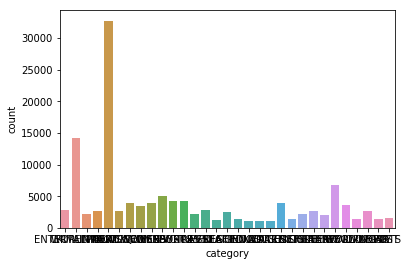

In [120]:
category_counter('category')
sns.countplot(x="category", data=df)

# *Clearly the category 'POLITICS' is very frequently occuring the headlines and its about 30 times of EDUCATION*

## *2. Generating the wordcloud*


In [121]:
from wordcloud import WordCloud, STOPWORDS
def wordcloud_generator(column):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=500,
                              max_font_size=50, 
                              random_state=42
                             ).generate(str(df[column]))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title("Title")



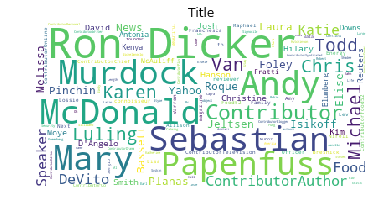

In [122]:
#WordCloud for the Authors
wordcloud_generator('authors')

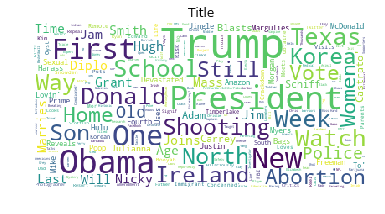

In [123]:
#wordcloud for the headlines
wordcloud_generator('headline')

## *You can clearly see the importance of Trump ( :D ) in the headlines,following by President !! *

## *Might be this dataset was taking during US Presidential Elections*

## *Counting the words in the Text:*

In [124]:
all_text_description = ' '.join([text for text in df['short_description']])
all_text_headline = ' '.join([text for text in df['headline']])
print('Number of words in description in all_text:', len(all_text_description))
print('Number of words in headline in all_text:', len(all_text_headline))

Number of words in description in all_text: 11675893
Number of words in headline in all_text: 7627227


In [125]:
df['news']=df['headline']+' '+df['short_description']

# *3. Data Preprocessing*

## *Decontraction Mapping for the words*

In [126]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [127]:
# df['headline'] = df.apply(lambda row: decontracted(row['headline']), axis=1)
# df['short_description']=df.apply(lambda row: decontracted(row['short_description']), axis=1)
df['news'] = df.apply(lambda row: decontracted(row['news']), axis=1)

In [128]:
# print(decontracted('I\'ll know that can\'t have it'))
df.head(10)

,authors,category,date,headline,link,short_description,news
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...
5,Ron Dicker,ENTERTAINMENT,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",Morgan Freeman 'Devastated' That Sexual Harass...
6,Ron Dicker,ENTERTAINMENT,2018-05-26,Donald Trump Is Lovin' New McDonald's Jingle I...,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",Donald Trump Is Lovin' New McDonald is Jingle ...
7,Todd Van Luling,ENTERTAINMENT,2018-05-26,What To Watch On Amazon Prime That’s New This ...,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,What To Watch On Amazon Prime That’s New This ...
8,Andy McDonald,ENTERTAINMENT,2018-05-26,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",Mike Myers Reveals He would 'Like To' Do A Fou...
9,Todd Van Luling,ENTERTAINMENT,2018-05-26,What To Watch On Hulu That’s New This Week,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,What To Watch On Hulu That’s New This Week You...


In [129]:
# df['news'][0]

## * Label Encoding the column 'Category' *

In [130]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['category']=le.fit_transform(df['category'])

In [131]:
df['category']

0          6
1          8
2          8
3          8
4          8
5          8
6          8
7          8
8          8
9          8
10         8
11        29
12        13
13        17
14        17
15        17
16        17
17        17
18        17
19        17
20        27
21         8
22        27
23        29
24        29
25        29
26        29
27         2
28         2
29         2
          ..
124959    17
124960     8
124961    23
124962     3
124963     5
124964     7
124965     4
124966    16
124967    28
124968    30
124969    17
124970    17
124971     3
124972    18
124973    30
124974    16
124975    13
124976    21
124977     0
124978    17
124979    17
124980    17
124981    28
124982     2
124983    17
124984    28
124985    23
124986     6
124987    15
124988    12
Name: category, Length: 124989, dtype: int64

## *Cleaning the text- Punctuation Cleaner*

In [132]:
all_text_in_headlines=''.join([p for p in df['headline']])
all_text_in_descriptions=''.join([p for p in df['short_description']])

In [133]:
import string
punctuations=string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

# df['headline'] = df['headline'].apply(lambda x: remove_punct(x))
# df['short_description']=df['short_description'].apply(lambda x:remove_punct(x))
df['news']=df['news'].apply(lambda x:remove_punct(x))
df.head(10)

,authors,category,date,headline,link,short_description,news
0,Melissa Jeltsen,6,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were Mass Shootings In Texas Last Week ...
1,Andy McDonald,8,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The ...
2,Ron Dicker,8,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age ...
3,Ron Dicker,8,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts Castrato Adam Schiff And Dem...
4,Ron Dicker,8,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...
5,Ron Dicker,8,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",Morgan Freeman Devastated That Sexual Harassme...
6,Ron Dicker,8,2018-05-26,Donald Trump Is Lovin' New McDonald's Jingle I...,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",Donald Trump Is Lovin New McDonald is Jingle I...
7,Todd Van Luling,8,2018-05-26,What To Watch On Amazon Prime That’s New This ...,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,What To Watch On Amazon Prime That’s New This ...
8,Andy McDonald,8,2018-05-26,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",Mike Myers Reveals He would Like To Do A Fourt...
9,Todd Van Luling,8,2018-05-26,What To Watch On Hulu That’s New This Week,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,What To Watch On Hulu That’s New This Week You...


## *Tokenization*

In [134]:
import nltk
# df['tokenized_headline'] = df.apply(lambda row: nltk.word_tokenize(row['headline']), axis=1)
# df['tokenized_short_description']=df.apply(lambda row: nltk.word_tokenize(row['short_description']), axis=1)
df['tokenized_news']=df.apply(lambda row:nltk.word_tokenize(row['news']),axis=1 )

In [135]:
df.head(3)

,authors,category,date,headline,link,short_description,news,tokenized_news
0,Melissa Jeltsen,6,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were Mass Shootings In Texas Last Week ...,"[There, Were, Mass, Shootings, In, Texas, Last..."
1,Andy McDonald,8,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The ...,"[Will, Smith, Joins, Diplo, And, Nicky, Jam, F..."
2,Ron Dicker,8,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age ...,"[Hugh, Grant, Marries, For, The, First, Time, ..."


## *Cleaning the URLs in the column 'link'*

In [136]:
#def getting_clean_url()

## *Removing StopWords *

In [137]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

In [138]:
# df['tokenized_headline'] = df['tokenized_headline'].apply(lambda x: remove_stopwords(x))
# df['tokenized_short_description']=df['tokenized_short_description'].apply(lambda x: remove_stopwords(x))
df['tokenized_news']=df['tokenized_news'].apply(lambda x: remove_stopwords(x))
df['news']=df['news'].apply(lambda x:remove_stopwords(x))

## *Stemming*

In [139]:
ps = nltk.PorterStemmer()
def text_stemmer(text):
    text = [ps.stem(word) for word in text]
    return text

In [140]:
# df['tokenized_headline'] = df['tokenized_headline'].apply(lambda x: text_stemmer(x))
# df['tokenized_short_description']=df['tokenized_short_description'].apply(lambda x: text_stemmer(x))
df['tokenized_news']=df['tokenized_news'].apply(lambda x: text_stemmer(x))
df['news']=df['news'].apply(lambda x:text_stemmer(x))

In [141]:
df['tokenized_news'].head(5)

0    [there, were, mass, shoot, In, texa, last, wee...
1    [will, smith, join, diplo, and, nicki, jam, fo...
2    [hugh, grant, marri, for, the, first, time, At...
3    [jim, carrey, blast, castrato, adam, schiff, a...
4    [julianna, marguli, use, donald, trump, poop, ...
Name: tokenized_news, dtype: object

## *Lemmetizing*

## * Lemmatize() function  assumes by default that the word is a Noun if there's no explict POS tag in the input. So We need to provide the POS tag while Lemmetizing*

In [142]:
from nltk import WordNetLemmatizer,pos_tag
wn1=WordNetLemmatizer()
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def text_lemmatizer(text):
    return [wn1.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(text)]

In [143]:
# df['tokenized_headline'] = df['tokenized_headline'].apply(lambda x: text_lemmatizer(x))
# df['tokenized_short_description']=df['tokenized_short_description'].apply(lambda x: text_lemmatizer(x))
df['tokenized_news']=df['tokenized_news'].apply(lambda x: text_lemmatizer(x))
# df['news']=df['news'].apply(lambda x:text_lemmatizer(x))

In [144]:
df.head(10)

,authors,category,date,headline,link,short_description,news,tokenized_news
0,Melissa Jeltsen,6,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,"[T, h, e, r, e, , W, e, r, e, , , M, , S, ...","[there, be, mass, shoot, in, texa, last, week,..."
1,Andy McDonald,8,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,"[W, l, l, , S, h, , J, n, , D, p, l, , A, ...","[will, smith, join, diplo, and, nicki, jam, fo..."
2,Ron Dicker,8,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,"[H, u, g, h, , G, r, n, , M, r, r, e, , F, ...","[hugh, grant, marri, for, the, first, time, at..."
3,Ron Dicker,8,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,"[J, , C, r, r, e, , B, l, , C, r, , A, , ...","[jim, carrey, blast, castrato, adam, schiff, a..."
4,Ron Dicker,8,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...","[J, u, l, n, n, , M, r, g, u, l, e, , U, e, ...","[julianna, marguli, use, donald, trump, poop, ..."
5,Ron Dicker,8,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...","[M, r, g, n, , F, r, e, e, n, , D, e, v, e, ...","[morgan, freeman, devast, that, sexual, harass..."
6,Ron Dicker,8,2018-05-26,Donald Trump Is Lovin' New McDonald's Jingle I...,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.","[D, n, l, , T, r, u, p, , I, , L, v, n, , ...","[donald, trump, be, lovin, new, mcdonald, jing..."
7,Todd Van Luling,8,2018-05-26,What To Watch On Amazon Prime That’s New This ...,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,"[W, h, , T, , W, c, h, , O, n, , A, z, n, ...","[what, to, watch, on, amazon, prime, that, ’, ..."
8,Andy McDonald,8,2018-05-26,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...","[M, k, e, , M, e, r, , R, e, v, e, l, , H, ...","[mike, myer, reveal, he, would, like, to, do, ..."
9,Todd Van Luling,8,2018-05-26,What To Watch On Hulu That’s New This Week,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,"[W, h, , T, , W, c, h, , O, n, , H, u, l, ...","[what, to, watch, on, hulu, that, ’, new, thi,..."


# *4. Data Preperation*

## *Create Embedding Matrix using GloVe50*

In [168]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.tokenized_news)
X_data=tokenizer.texts_to_sequences(df.tokenized_news)
# print(X_data[0])

In [169]:
word_index = tokenizer.word_index
print(type(word_index))
print('Total %s unique tokens.' % len(word_index))

<class 'dict'>
Total 52734 unique tokens.


In [170]:
print(X_data[0])
print(df['tokenized_news'][0])

[122, 4, 906, 209, 6, 490, 121, 78, 55, 622, 15, 422, 145, 520, 937, 46, 127, 86, 118, 186, 30, 109]
['there', 'be', 'mass', 'shoot', 'in', 'texa', 'last', 'week', 'but', 'onli', 'on', 'tv', 'she', 'leave', 'husband', 'he', 'kill', 'child', 'just', 'anoth', 'day', 'america']


In [171]:
embed_size=50
input_length=100

In [172]:
embeddings_index = {}
f = open('../input/glove50/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [173]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 26363 which is 49.99 % of total words


In [174]:
print(embedding_matrix[122])
print(embeddings_index['there'])

[ 0.68491     0.32385001 -0.11592    -0.35925001  0.49889001  0.042541
 -0.40153    -0.36793    -0.61440998 -0.41148001 -0.34819999 -0.21952
 -0.22393    -0.64965999  0.85443002  0.33581999  0.2931      0.16552
 -0.55081999 -0.61277002 -0.14768     0.47551     0.65877002 -0.07103
  0.56146997 -1.2651     -0.74116999  0.36364999  0.56230003 -0.27364999
  3.8506      0.27645001 -0.1009     -0.71568     0.18511    -0.12312
  0.56630999 -0.22376999 -0.016831    0.57538998 -0.51761001  0.033823
  0.19643     0.63498002 -0.24866     0.038716   -0.50559002  0.17873999
 -0.1693      0.062375  ]
[ 0.68491   0.32385  -0.11592  -0.35925   0.49889   0.042541 -0.40153
 -0.36793  -0.61441  -0.41148  -0.3482   -0.21952  -0.22393  -0.64966
  0.85443   0.33582   0.2931    0.16552  -0.55082  -0.61277  -0.14768
  0.47551   0.65877  -0.07103   0.56147  -1.2651   -0.74117   0.36365
  0.5623   -0.27365   3.8506    0.27645  -0.1009   -0.71568   0.18511
 -0.12312   0.56631  -0.22377  -0.016831  0.57539  -0.51

## *Data Preparation*

In [238]:
max_features=200000
max_senten_len=75
max_senten_num=4
embed_size=50
VALIDATION_SPLIT = 0.1

In [239]:
news=df['tokenized_news']
print(news.head())

0    [there, be, mass, shoot, in, texa, last, week,...
1    [will, smith, join, diplo, and, nicki, jam, fo...
2    [hugh, grant, marri, for, the, first, time, at...
3    [jim, carrey, blast, castrato, adam, schiff, a...
4    [julianna, marguli, use, donald, trump, poop, ...
Name: tokenized_news, dtype: object


## *Creating Embedding Layer*

In [240]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index)+1,
                            embed_size,
                            input_length=max_senten_len,
                            trainable=False)


In [241]:
from keras.preprocessing import sequence
# df['embedding_indexed_news']=df['tokenized_news'].apply(lambda x: embedding_m)
X = list(sequence.pad_sequences(X_data, maxlen=max_senten_len))

In [242]:
from keras import utils
print(len(X))
X=np.array(X)
print(X.shape)
Y=utils.np_utils.to_categorical(df.category)
print(Y.shape)
print(Y[0])

124989
(124989, 75)
(124989, 31)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


# *Training ,Testing ,Validation Splitting of Data*

In [243]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25)

# *Defining Architecture for RNN - Single Layer Bidirectional LSTM*

In [247]:
from keras.layers import Input , Dense , LSTM,GlobalAveragePooling1D,GlobalMaxPooling1D,Bidirectional,LSTM,Conv1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
def classifier():
    inp = Input(shape=(max_senten_len,), dtype='int32')
    x = embedding_layer(inp)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(x)
    outp = Dense(31, activation="softmax")(x)
    BiLSTM = Model(inp, outp)
    BiLSTM.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
    print(BiLSTM.summary())
    return BiLSTM
    

In [248]:
model1=classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 75, 50)            2636750   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               183296    
_________________________________________________________________
dense_8 (Dense)              (None, 31)                7967      
Total params: 2,828,013
Trainable params: 191,263
Non-trainable params: 2,636,750
_________________________________________________________________
None


In [249]:
print(X_train[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1   282    13   415     8  8518 39472    46     9   826
   320   837    47  2672  5086  9970    46     9   401   128   102  6086
   112  6878   218]


In [250]:
histo=model1.fit(X_train,Y_train,batch_size=128,epochs=2,validation_split=0.25)

Train on 70305 samples, validate on 23436 samples
Epoch 1/2
32640/70305 [============>.................] - ETA: 1:26 - loss: 3.2432 - acc: 0.2561

KeyboardInterrupt: 

# *26 percent accuracy in two epochs !!!*

# *Work in still going on !!  Will be update Later*